---
# Predicting house prices in Ames, Iowa
---

#### Libraries

In [1]:
#base
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import mode
import math
#visualisation
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from  matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline
#machine learning
from sklearn.preprocessing import scale
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.dummy import DummyRegressor
from scipy.linalg import lstsq
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
#reporting
import docx
from docx import Document
from docx.shared import Cm, Pt
import stitch
#operating system, directories
import os

#### Load data

In [2]:
raw_data = pd.read_csv('house-prices.csv') # load data
print(raw_data.shape) # print df size
raw_data.head() # print head

(2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


# Data Preparation
---

## Missing values

The first thing we'll do is look for duplicates and missing data. We will print a list with the number of missing values per feature, and also plot the percentage of missing values per feature.

Duplicated rows: 0
Duplicated IDs: 0
Missing values: 11670
                   n
Pool QC         2418
Misc Feature    2340
Alley           2267
Fence           1941
Fireplace Qu    1186
Lot Frontage     420
Garage Cond      138
Garage Qual      138
Garage Finish    138
Garage Yr Blt    138
Garage Type      136
Bsmt Exposure     74
BsmtFin Type 2    72
BsmtFin Type 1    71
Bsmt Qual         71
Bsmt Cond         71
Mas Vnr Area      20
Mas Vnr Type      20
Bsmt Half Bath     2
Bsmt Full Bath     2
Total Bsmt SF      1
Bsmt Unf SF        1
Garage Cars        1
Garage Area        1
BsmtFin SF 2       1
BsmtFin SF 1       1
Electrical         1


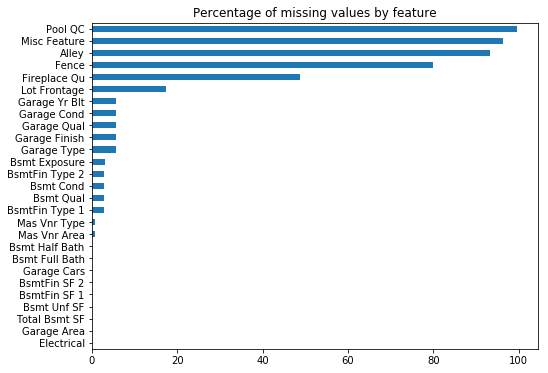

In [3]:
# Duplicates
print('Duplicated rows:', raw_data.duplicated().sum()) # check for perfect duplicates
print('Duplicated IDs:', raw_data.duplicated(subset=('PID')).sum()) # check for duplicated IDs

# Missing values
print('Missing values:', raw_data.isnull().sum().sum()) # print sum of missing values accross all features
nan = raw_data.isnull().sum().to_frame('n') # sum missing values by feature, put to a df
print(nan[nan['n'] > 0].sort_values(by='n', ascending=False)) # print features with missing values and missing values number
nan_percent = nan[nan['n'] > 0].sort_values(by='n')/ raw_data.shape[0] * 100


# Plot percentage of missing values by feature
nan_percent.plot.barh(legend=None, figsize=(8, 6))
plt.title('Percentage of missing values by feature')
plt.show()

We will handle missing values using the following strategy:

**Features with more than 95% missing values**

Since 'Pool QC' and 'Misc Feature' consist mostly of missing data, we will completely remove them. Note we will lose very little information, because we also have a continuous feature for both of them ('Pool Area' and 'Misc Val', respectively). These can not only be used in analyses, but might even be more useful.

**Variables with 50-95% missing values**

'Alley' describe the type of alley, and 'Fence' describe the quality of the fence. However these features are between 79-93% empty, because most houses don't have an alley or fence. Rather than completely removing them, we will simply recode them to 'yes' or 'no', to indicate whether or not they possess an alley or fence. This will allow us to keep essential (and arguably more useful) information about the houses.

'FireplaceQu' has 49% missing data, however it has a continuous feature near-equivalent, 'Fireplaces' or the number of fireplace in the property. Again this means we will lose little information here, especially if we consider that the number of fireplaces is a more promising predictor than the quality of some of the fireplaces. We will therefore completely remove 'FireplaceQu'.

**Features with less than 20% missing values**

For 'Lot Frontage' (18% missing) we will replace missing values with the median. For the Garage variables and the Bsmt variables (3-6% missing values), we will create a new overall yes/no feature, and replace missing values in the existing features with the median or most frequent category. The rationale for creating a new yes/no feature is to retain information about houses that do <ins>not</ins> have a garage or basement, which will be lost when replacing the missing values.

For all other features (less than 1% missing), we will replace missing values with the median or most frequent category.

We will also fix an issue with the variable 'Garage Yr Blt' (which has a 2027 value instead of 2007), which needs to be addressed before continue processing the data.

In [4]:
# Drop 'Pool Qc', 'Misc Feature', and 'Fireplace Qu'
raw_data2 = raw_data.drop(['Pool QC', 'Misc Feature', 'Fireplace Qu'], axis = 1) # drop features

# Recode 'Alley' and 'Fence' to yes/no
raw_data2['Alley'] = raw_data2['Alley'].replace({'Grvl':'Yes', 'Pave':'Yes'}).fillna(value='No') # Alley
raw_data2['Fence'] = raw_data2['Fence'].replace({'MnPrv':'Yes', 'GdPrv':'Yes', 'GdWo':'Yes', 'MnWw':'Yes'}).fillna(value='No') # Fence

# Replace 'Lot Frontage' missing values by median
raw_data2['Lot Frontage'] = raw_data2['Lot Frontage'].fillna(value=raw_data2['Lot Frontage'].median())

# Create yes/no feature for Garage and Basement
raw_data2['Garage'] = raw_data2['Garage Type'].replace({'Attchd':'Yes', 'Detchd':'Yes', 'BuiltIn':'Yes', 'Basment':'Yes', '2Types':'Yes', 'CarPort':'Yes'}).fillna(value='No')
raw_data2['Basement'] = raw_data2['Bsmt Qual'].replace({'TA':'Yes', 'Gd':'Yes', 'Ex':'Yes', 'Fa':'Yes', 'Po':'Yes'}).fillna(value='No')

# Replace missing values in Garage and Basement features with most frequent category
raw_data2['Garage Type'].fillna(value=raw_data2['Garage Type'].value_counts().index[0], inplace=True)
raw_data2['Garage Finish'].fillna(value=raw_data2['Garage Finish'].value_counts().index[0], inplace=True)
raw_data2['Garage Qual'].fillna(value=raw_data2['Garage Qual'].value_counts().index[0], inplace=True)
raw_data2['Garage Cond'].fillna(value=raw_data2['Garage Cond'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Exposure'].fillna(value=raw_data2['Bsmt Exposure'].value_counts().index[0], inplace=True)
raw_data2['BsmtFin Type 2'].fillna(value=raw_data2['BsmtFin Type 2'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Cond'].fillna(value=raw_data2['Bsmt Cond'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Qual'].fillna(value=raw_data2['Bsmt Qual'].value_counts().index[0], inplace=True)
raw_data2['BsmtFin Type 1'].fillna(value=raw_data2['BsmtFin Type 1'].value_counts().index[0], inplace=True)

# Replace all other missing values with most frequent category or median
raw_data2['Electrical'].fillna(value=raw_data2['Electrical'].value_counts().index[0], inplace=True)
raw_data2['Garage Area'].fillna(value=raw_data2['Garage Area'].median(), inplace=True) #object
raw_data2['Total Bsmt SF'].fillna(value=raw_data2['Total Bsmt SF'].median(), inplace=True) #object
raw_data2['Bsmt Unf SF'].fillna(value=raw_data2['Bsmt Unf SF'].median(), inplace=True) #object
raw_data2['BsmtFin SF 1'].fillna(value=raw_data2['BsmtFin SF 1'].median(), inplace=True) #object
raw_data2['BsmtFin SF 2'].fillna(value=raw_data2['BsmtFin SF 2'].median(), inplace=True) #object
raw_data2['Garage Cars'].fillna(value=raw_data2['Garage Cars'].median(), inplace=True) #float
raw_data2['Bsmt Full Bath'].fillna(value=raw_data2['Bsmt Full Bath'].median(), inplace=True) #float
raw_data2['Bsmt Half Bath'].fillna(value=raw_data2['Bsmt Half Bath'].median(), inplace=True) #float
raw_data2['Mas Vnr Area'].fillna(value=raw_data2['Mas Vnr Area'].median(), inplace=True) #object
raw_data2['Mas Vnr Type'].fillna(value=raw_data2['Mas Vnr Type'].value_counts().index[0], inplace=True)

# Fix issue with 'Garage Yr Blt'
raw_data2['Garage Yr Blt'].replace({2207:2007}, inplace=True)
raw_data2['Garage Yr Blt'].fillna(value=raw_data['Garage Yr Blt'].median(), inplace=True)


# Check that all missing values have been removed
print('Remaining missing values:', raw_data2.isnull().sum().sum())
print('New df size:', raw_data2.shape, '--> note we removed 3 features and added 2 features, resulting in 81 features')

Remaining missing values: 0
New df size: (2430, 81) --> note we removed 3 features and added 2 features, resulting in 81 features


## Cleaning non-continuous variables

The first thing we'll do is plot all the non-continuous variables. This will give us a good overview of the data and allow us to spot any issues.

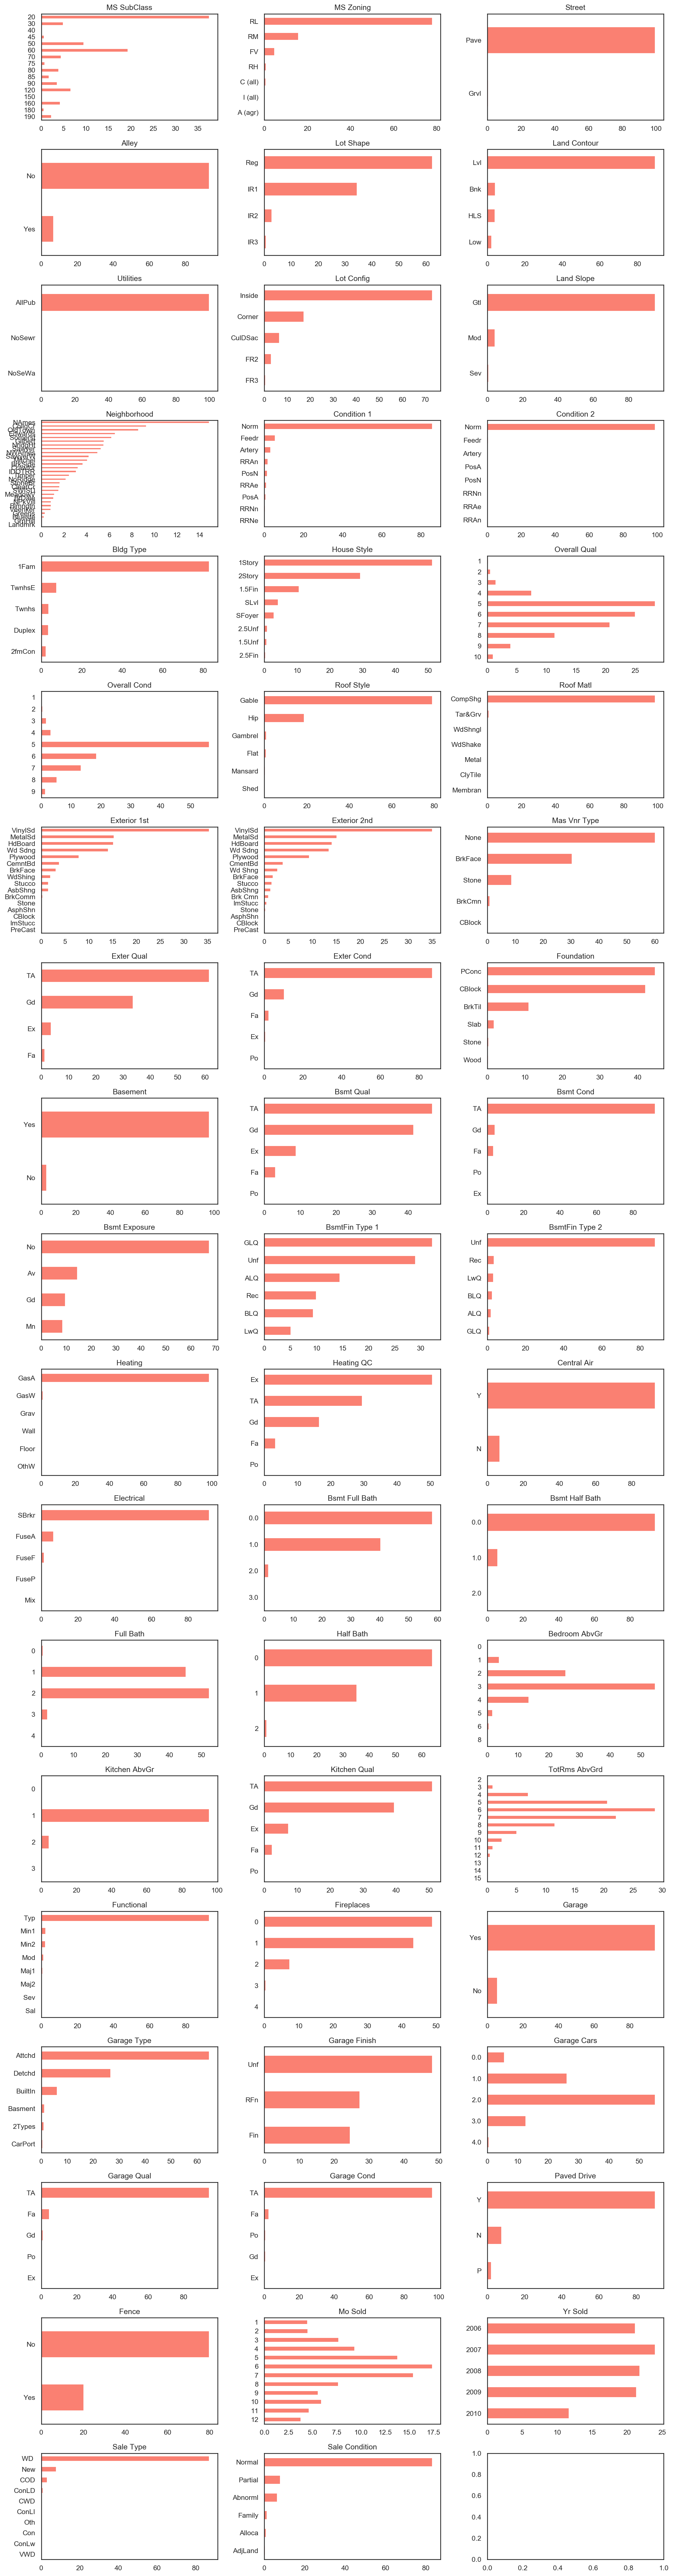

In [5]:
#select variables
cat_vars = raw_data2[['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
                     'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
                     'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl', 'Exterior 1st',
                     'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Basement', 'Bsmt Qual',
                     'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
                     'Central Air', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
                     'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
                     'Garage', 'Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Qual', 'Garage Cond',
                     'Paved Drive', 'Fence', 'Mo Sold', 'Yr Sold', 'Sale Type',
                     'Sale Condition']]
# Not included:
 #Year Built (too many levels)
 #Year Remod/Add (same)
 #Garage Yr Blt (same)

#set style
plt.rcParams['figure.dpi'] = 150
sns.set(style="white", palette='dark:salmon_r')

#plot
ncols = 3
nrows = int(np.ceil(cat_vars.shape[1] / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(5*ncols, 3*nrows))
for ax, (name, g) in zip(axes.ravel(), cat_vars.items()):
    z = g.value_counts(normalize=True, ascending=True) * 100
    if isinstance(z.index, (pd.Float64Index, pd.Int64Index)):
        z = z.sort_index(ascending=False)  # might make more sense for ordinal categories
    z.plot.barh(ax=ax)
    ax.title.set_text(name)

plt.tight_layout()

# Parts of this code were inspired by this question I posted on StackOverflow: https://stackoverflow.com/questions/66078476/function-to-automate-creation-of-ungrouped-bar-plots

### Drop features

We note that some features have several categories, but that nearly all data fall into a single category. For example, the variable 'Street' has 2 categories ('Pave' and 'Grvl'), but 99.5% of the houses fall into 'Pave':

In [6]:
raw_data2['Street'].value_counts(normalize=True)

Pave    0.995473
Grvl    0.004527
Name: Street, dtype: float64

It is very unlikely that this and other similar features will help explain the house prices, so we will simply remove them from our data set:

In [7]:
# Drop features with more than 98% of data in single category
raw_data3 = raw_data2.drop(['Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Heating'], axis = 1)
print('New df size:', raw_data3.shape, '--> note we now have 76 features')

New df size: (2430, 76) --> note we now have 76 features


### Recode features

We will now recode some features depending on their type.

**Ordinal variables**

For ordinal variables, we will recode them as numeric scales. The reason for this is that we want to limit the matrix dimensionality. If all ordinal variables were one-hot encoded, we would end up with a large number of variables for modelling, which should be avoided if possible.

**Nominal variables**

We will keep them as is, before one-hot encoding them later. Here we'll just check whether they are consistent, and convert one to categorical type.

**Discrete variables**

We will keep them as is, and treat them as continuous variables rather than one-hot encoding them. This makes sense if we consider, for example, that the total number of rooms (a discrete feature) should likely have an impact on the house price in the same way as other continuous variables.

**Other**

We will transform three date variables into durations. Note we do not transform 'Mo Sold' and 'Yr Sold' since these might be useful as is.

In [8]:
# Recode ordinal variables
raw_data3['Exter Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Exter Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Exposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}, inplace=True) # note smaller scale
raw_data3['Heating QC'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Kitchen Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Garage Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Garage Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)

# Define 'MS SubClass' as categorical data
raw_data3['MS SubClass'] = raw_data3['MS SubClass'].astype('category')

# Dates
raw_data3['Year Remod/Add_bis'] = raw_data3['Year Remod/Add'] - raw_data3['Year Built'] # transform renovation year to number of years between year built and renovation. Note order matters here!
raw_data3['Year Built'] = 2021 - raw_data3['Year Built'] # transform year built to number of years since house was built
raw_data3['Garage Yr Blt'] = 2021 - raw_data3['Garage Yr Blt'] # transform garage year built to number of years since garage was built

# Note we do not transform 'Mo Sold' and 'Yr Sold' (we just convert 'Yr Sold' to integer to avoid an issue later)

print('New df size:', raw_data3.shape, '--> note we now have 77 features')

New df size: (2430, 77) --> note we now have 77 features


## Cleaning continuous variables

      Gr Liv Area  SalePrice
71           5095     183850
102          4476     745000
237          4316     755000
1500         5642     160000


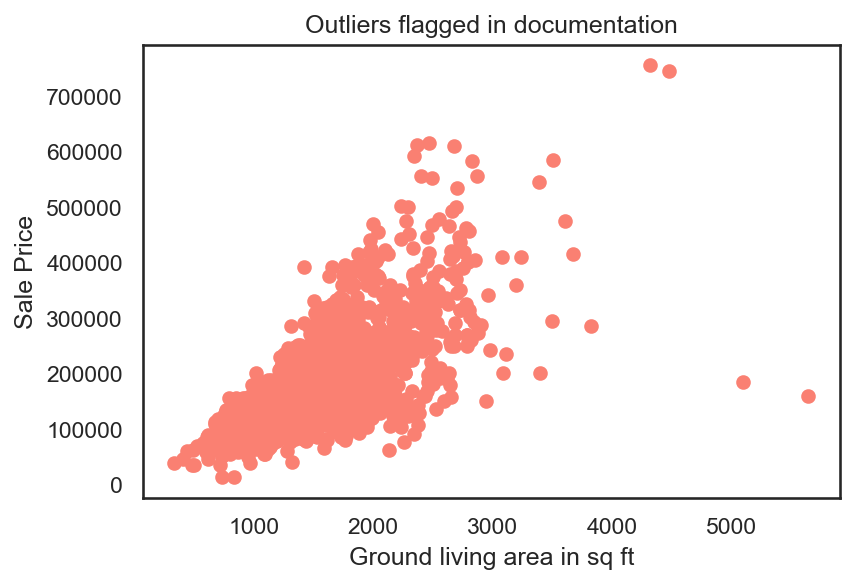

Outliers removed: 4
New df size: (2426, 77)


In [9]:
# Documentation recommends to remove these 4 outliers (note documentation mentions 5 outliers, but the last one is in the test data file with 500 samples):
print(raw_data3[raw_data3['Gr Liv Area'] > 4000][['Gr Liv Area', 'SalePrice']])
plt.scatter(raw_data3['Gr Liv Area'], raw_data3['SalePrice'])
plt.title('Outliers flagged in documentation')
plt.xlabel('Ground living area in sq ft')
plt.ylabel('Sale Price')
plt.show()

# Define outliers
outliers_doc = raw_data3[raw_data3['Gr Liv Area'] > 4000]
print('Outliers removed:', outliers_doc.shape[0])

# Remove outliers and redefine df
raw_data3 = raw_data3.drop(outliers_doc.index, axis=0)
print('New df size:', raw_data3.shape)

We also remove obvious errors. For example, Lot Frontage has an observation that deviates more than 10 times the sd:

Max value of Lot Frontage: 313.0
Z-score of max value: 11.813031230006308


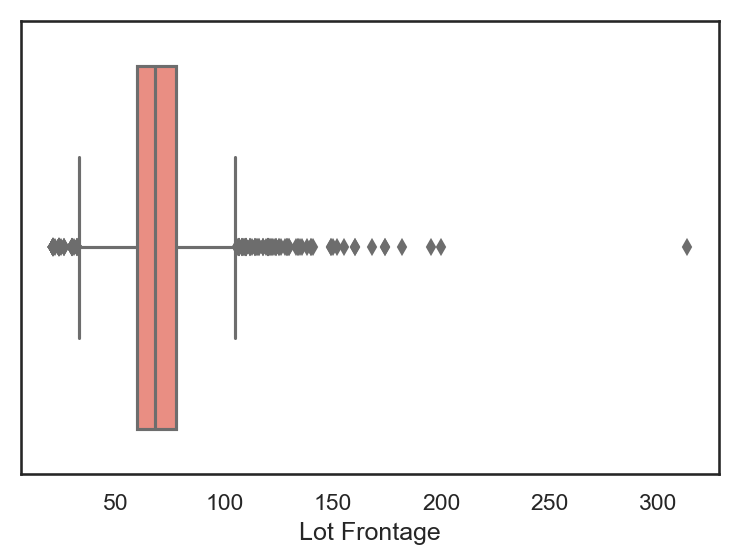

In [10]:
print('Max value of Lot Frontage:', raw_data3['Lot Frontage'].max())
print('Z-score of max value:', (raw_data3['Lot Frontage'].max()-raw_data3['Lot Frontage'].mean()) / raw_data3['Lot Frontage'].std())
sns.boxplot(x=raw_data3['Lot Frontage'])
plt.show()

We will therefore remove all other observations that deviate more than 10 times from their respective standard deviations:

In [11]:
cont_vars = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
                    '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
                    'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice',
                    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual',
                    'Garage Qual', 'Garage Cond', 'Year Remod/Add', 'Year Remod/Add_bis', 'Year Built', 'Garage Yr Blt', 'Mo Sold',
                    'Yr Sold', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Fireplaces', 'Overall Qual', 'Overall Cond', 'Bsmt Full Bath',
                    'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Kitchen AbvGr']


z_scores = (raw_data3[cont_vars] - raw_data3[cont_vars].mean()) / raw_data3[cont_vars].std()
filter = np.abs(z_scores) > 10
print('Number of errors:', filter.sum(axis=0).sum()) # check number is same as above
filter_any = filter.any(axis=1)
outliers = raw_data3.loc[filter_any, :]
print('Number of errors removed:', outliers.shape[0], '--> note difference is likely due to the fact that one observation was flagged on several features')

# Remove and save clean df
raw_data3 = raw_data3.drop(outliers.index, axis=0).copy()
print('New df shape:', raw_data3.shape)

Number of errors: 36
Number of errors removed: 35 --> note difference is likely due to the fact that one observation was flagged on several features
New df shape: (2391, 77)


Let's now take a closer look at the distributions of our features:

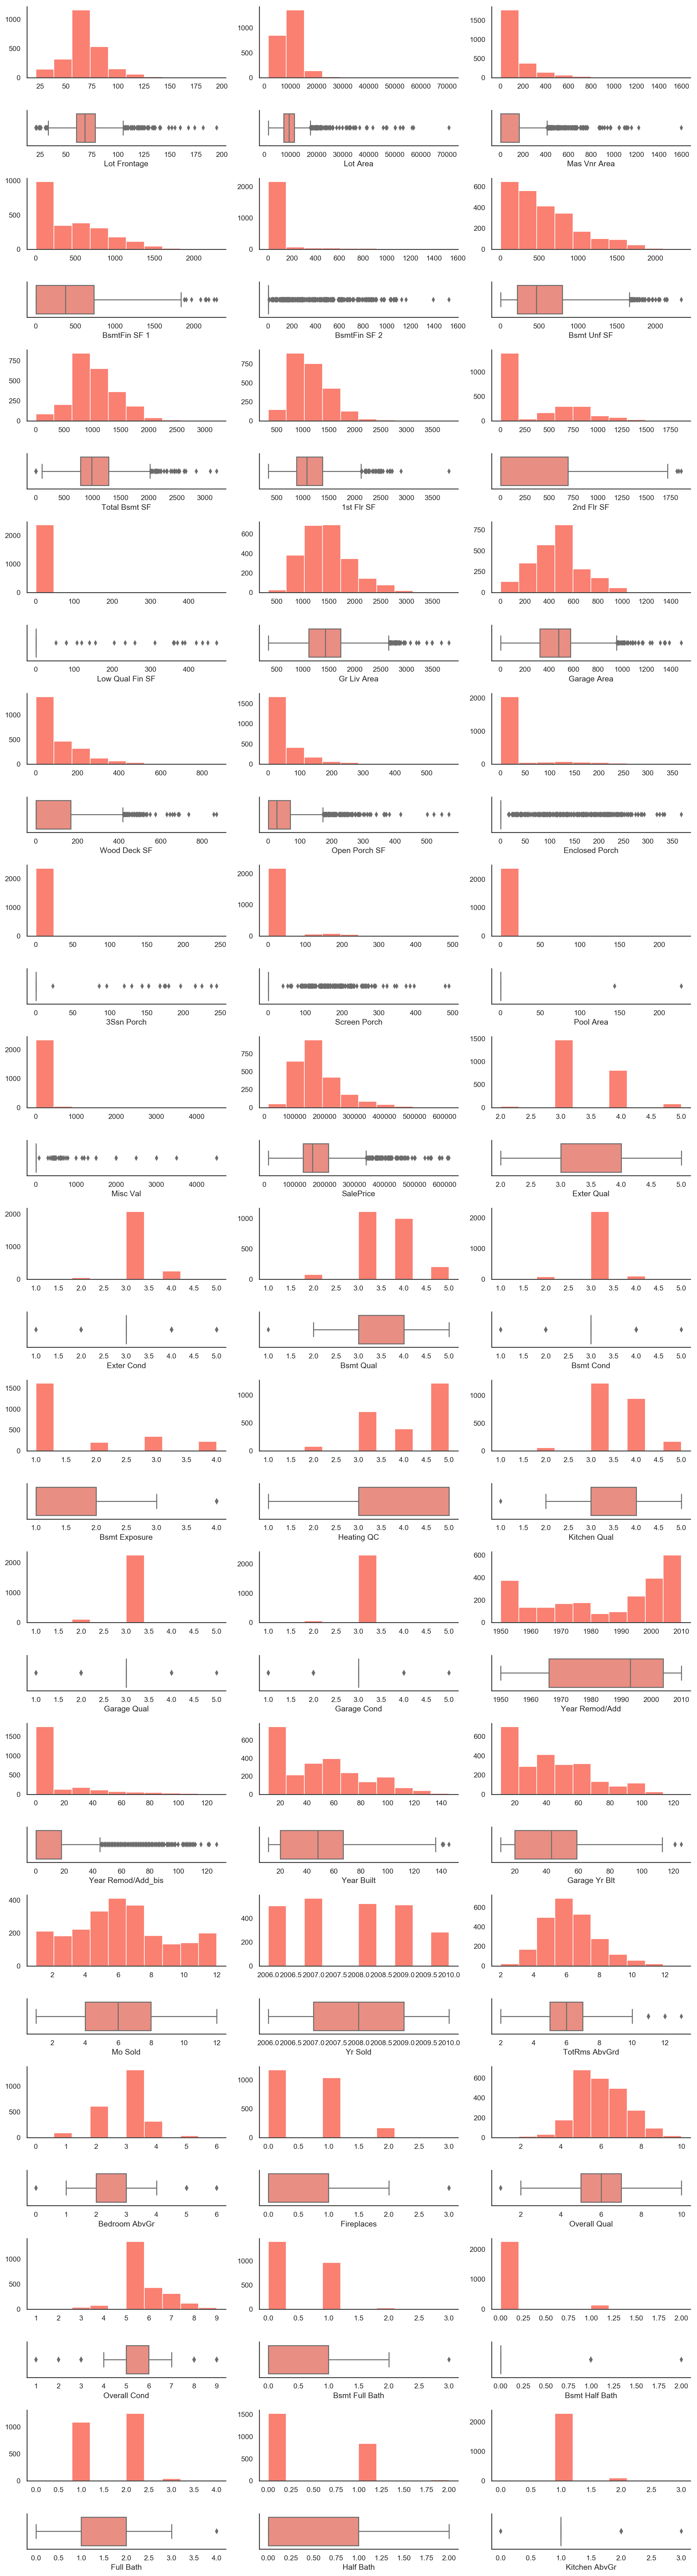

In [12]:
# Number of subplots needed: 2 * 45 = 90 (please see list of variables treated as continuous at the very end of this notebook)

# Plot
cont_vars = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
                    '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
                    'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice',
                    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual',
                    'Garage Qual', 'Garage Cond', 'Year Remod/Add', 'Year Remod/Add_bis', 'Year Built', 'Garage Yr Blt', 'Mo Sold',
                    'Yr Sold', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Fireplaces', 'Overall Qual', 'Overall Cond', 'Bsmt Full Bath',
                    'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Kitchen AbvGr']

fig, axes = plt.subplots(
    nrows=30,  
    ncols=3,  
    gridspec_kw={"height_ratios": (2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1)},  
    figsize=(15, 55))

# Store indices of which feature histogram/boxplot we plotted
feature_histogram_index = 0
feature_boxplot_index = 0

for row_index, row in enumerate(axes):

    # If the row index is even, then we will plot histograms
    if row_index % 2 == 0:

        # Special case: last histogram row (index==6) has only 2 subplots
        #row = row[:2] if row_index == 22 else row

        # Fill in all subplots there
        for subplot in row:
            subplot.hist(raw_data3[cont_vars[feature_histogram_index]])
            feature_histogram_index += 1
            sns.despine(ax=subplot)

    # If the row index is odd, then we will plot boxplots
    else:

        # Special case: last boxplot row (index==7) has only 2 subplots
        #row = row[:2] if row_index == 23 else row

        # Fill in all subplots there
        for subplot in row:
            sns.boxplot(x=raw_data3[cont_vars[feature_boxplot_index]], ax=subplot)
            feature_boxplot_index += 1
            sns.despine(ax=subplot)

plt.tight_layout()

# Check here: https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/course-project-v12/github_projects/3388
# Thank you, Arnaud!

### Skewness and Outliers

From a quick look at the plots above, we can see 2 things: most variables are positively skewed, and most variables have outliers.

We will first address skewness, by log-transforming the variables in question, including our output feature, SalePrice. We will then remove outliers using the z-scores method.

In [13]:
# Have a look at outliers before doing any transformation
z_score_method = np.abs(raw_data3[cont_vars] - raw_data3[cont_vars].mean()) > (3 * raw_data3[cont_vars].std())
print(z_score_method.sum(axis=0))
print('Maximum number of outliers with z-score higher than 3:', z_score_method.sum(axis=0).sum())

Lot Frontage           24
Lot Area               31
Mas Vnr Area           51
BsmtFin SF 1           14
BsmtFin SF 2           79
Bsmt Unf SF            13
Total Bsmt SF          17
1st Flr SF             22
2nd Flr SF              6
Low Qual Fin SF        17
Gr Liv Area            12
Garage Area            11
Wood Deck SF           36
Open Porch SF          49
Enclosed Porch         84
3Ssn Porch             21
Screen Porch           90
Pool Area               2
Misc Val               22
SalePrice              39
Exter Qual              0
Exter Cond             15
Bsmt Qual               1
Bsmt Cond             184
Bsmt Exposure           0
Heating QC              2
Kitchen Qual            1
Garage Qual           134
Garage Cond            89
Year Remod/Add          0
Year Remod/Add_bis     64
Year Built              6
Garage Yr Blt           6
Mo Sold                 0
Yr Sold                 0
TotRms AbvGrd          28
Bedroom AbvGr          19
Fireplaces              9
Overall Qual

Let's transform the positively skewed features:

In [14]:
log1p_transform = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2','Bsmt Unf SF', 
          '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF',
          'Enclosed Porch', 'Bsmt Exposure', 'Year Remod/Add_bis',
          'Year Built', 'Garage Yr Blt', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Fireplaces', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
          'Kitchen AbvGr', 'Overall Cond', 'SalePrice']

untransformed = ['Lot Frontage', 'Lot Area', 'Exter Qual', 'Bsmt Cond', 'Kitchen Qual', 'Garage Qual', 'Garage Cond','Mo Sold', 'Yr Sold',
          'Overall Qual', 'Full Bath', 'Total Bsmt SF', 'Garage Area', 'Screen Porch', 'Misc Val', 'Exter Cond','Low Qual Fin SF', '3Ssn Porch', 'Pool Area']

# Apply log transformations
raw_data3[log1p_transform] = np.log1p(raw_data3[log1p_transform])

Now that our features are approximately symmetric, we see that there are 500 less observations flaged as outliers. This suggests that the transformation has helped:

In [15]:
z_score_method = np.abs(raw_data3[cont_vars] - raw_data3[cont_vars].mean()) > (3 * raw_data3[cont_vars].std())
print(z_score_method.sum(axis=0))
print('Maximum number of outliers with z-score higher than 3:', z_score_method.sum(axis=0).sum())

Lot Frontage           24
Lot Area               31
Mas Vnr Area            0
BsmtFin SF 1            0
BsmtFin SF 2           79
Bsmt Unf SF             0
Total Bsmt SF          17
1st Flr SF              5
2nd Flr SF              0
Low Qual Fin SF        17
Gr Liv Area             9
Garage Area            11
Wood Deck SF            0
Open Porch SF           0
Enclosed Porch          0
3Ssn Porch             21
Screen Porch           90
Pool Area               2
Misc Val               22
SalePrice              16
Exter Qual              0
Exter Cond             15
Bsmt Qual               1
Bsmt Cond             184
Bsmt Exposure           0
Heating QC              2
Kitchen Qual            1
Garage Qual           134
Garage Cond            89
Year Remod/Add          0
Year Remod/Add_bis      0
Year Built              0
Garage Yr Blt           0
Mo Sold                 0
Yr Sold                 0
TotRms AbvGrd           2
Bedroom AbvGr           8
Fireplaces              0
Overall Qual

In [16]:
# Remove features that add no value
raw_data3 = raw_data3.drop(['BsmtFin SF 2', 'Screen Porch', 'Bsmt Cond', 'Garage Qual', 'Garage Cond', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Pool Area'], axis = 1).copy()
print('New df size:', raw_data3.shape, '--> note we now have 69 features')

New df size: (2391, 69) --> note we now have 69 features


We can now remove outliers using the z-score method:

In [17]:
# Redefine cont_vars
cont_vars = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
                    '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
                    'Enclosed Porch', '3Ssn Porch', 'Misc Val', 'SalePrice',
                    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual',
                    'Year Remod/Add', 'Year Remod/Add_bis', 'Year Built', 'Garage Yr Blt', 'Mo Sold',
                    'Yr Sold', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Fireplaces', 'Overall Qual', 'Overall Cond', 'Bsmt Full Bath',
                    'Full Bath', 'Half Bath']

z_score_method = np.abs(raw_data3[cont_vars] - raw_data3[cont_vars].mean()) > (3 * raw_data3[cont_vars].std())
print(z_score_method.sum(axis=0))
print('Maximum number of outliers with z-score higher than 3:', z_score_method.sum(axis=0).sum())

Lot Frontage          24
Lot Area              31
Mas Vnr Area           0
BsmtFin SF 1           0
Bsmt Unf SF            0
Total Bsmt SF         17
1st Flr SF             5
2nd Flr SF             0
Low Qual Fin SF       17
Gr Liv Area            9
Garage Area           11
Wood Deck SF           0
Open Porch SF          0
Enclosed Porch         0
3Ssn Porch            21
Misc Val              22
SalePrice             16
Exter Qual             0
Exter Cond            15
Bsmt Qual              1
Bsmt Exposure          0
Heating QC             2
Kitchen Qual           1
Year Remod/Add         0
Year Remod/Add_bis     0
Year Built             0
Garage Yr Blt          0
Mo Sold                0
Yr Sold                0
TotRms AbvGrd          2
Bedroom AbvGr          8
Fireplaces             0
Overall Qual           4
Overall Cond          15
Bsmt Full Bath         2
Full Bath              3
Half Bath              0
dtype: int64
Maximum number of outliers with z-score higher than 3: 226


In [18]:
# actually remove them
z_scores = (raw_data3[cont_vars] - raw_data3[cont_vars].mean()) / raw_data3[cont_vars].std()
filter = np.abs(z_scores) > 3
print('Check if same number as above:', filter.sum(axis=0).sum()) # check number is same as above
filter_any = filter.any(axis=1)
outliers = raw_data3.loc[filter_any, :]
print('Final number of outliers:', outliers.shape[0])

# Remove and save clean df
clean_data = raw_data3.drop(outliers.index, axis=0)
print('Clean data shape:', clean_data.shape)
print('Features removed:', raw_data.shape[1] - clean_data.shape[1])
print('Total observations removed:', raw_data.shape[0] - clean_data.shape[0])

Check if same number as above: 226
Final number of outliers: 190
Clean data shape: (2201, 69)
Features removed: 13
Total observations removed: 229


# Feature Engineering
---

We have already created 4 features during data preparation, that is, whether or not the houses have a basement, garage, alley, and fence. Here we will create one more, and later we will also add polynomial features, directly into the preprocessing function (please see Complex model). We will also make a log-transformation later to address the positive skew in the data directly as part of our preprocessing function. So here we are just adding one feature. We can always add more later if needed.

### Adding binary variable: was the house renovated just before the sale?

It seems likely that whether or not a house was renovated should have an influence on the price, especially if the renovation occurred just before the sale. We will therefore add a feature that encode whether or not the house was renovated just before the sale, that is, on the same year or up to 1 year before the sale.

Counts:
No     1887
Yes     314
Name: Renovated before sale, dtype: int64


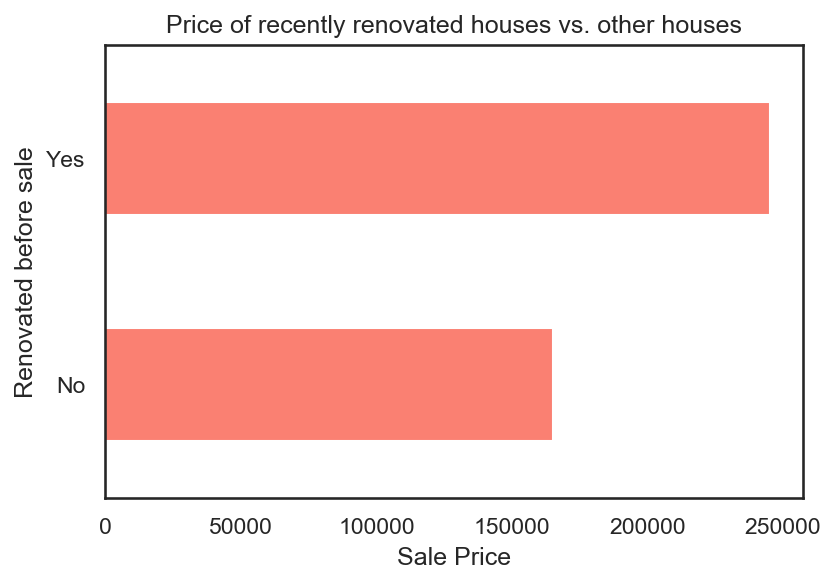

Renovated before sale
No     164976.0
Yes    245116.0
Name: SalePrice$, dtype: float64
Sale Price mean 176409.0
Sale Price sd 69887.0


In [19]:
# Add feature
clean_data['Renovated before sale'] = clean_data['Yr Sold'] - clean_data['Year Remod/Add']

# Create function to recode as renovated before sale
def binary(x):
    if x < 2: # houses that were renovated on the same year or up to one year before the sale
        code = 'Yes'
    else:
        code = 'No'
    return code

# Apply function
clean_data['Renovated before sale'] = clean_data['Renovated before sale'].apply(binary)

# Print counts
print('Counts:')
print(clean_data['Renovated before sale'].value_counts())

# create feature with Sale Price in $
clean_data['SalePrice$'] = np.expm1(clean_data['SalePrice'])

# Plot average sale price by new feature
clean_data.groupby('Renovated before sale').mean('SalePrice$').round()['SalePrice$'].plot.barh()
plt.xlabel('Sale Price')
plt.title('Price of recently renovated houses vs. other houses')
plt.show()
print(clean_data.groupby('Renovated before sale').mean('SalePrice$').round()['SalePrice$']) # print stats
print('Sale Price mean', clean_data['SalePrice$'].mean().round())
print('Sale Price sd', clean_data['SalePrice$'].std().round())

Our intuition was correct: houses that were renovated up to one year preceding the sale have a higher mean price than those that were not renovated recently. Note the difference is large, that is, more than one standard deviation compared to the overall mean of Sale Price.

### Adding polynomial features

Some of our features are strongly correlated to SalePrice (see next section), hovewer their relationship with SalePrice is not linear. In particular, these three features:

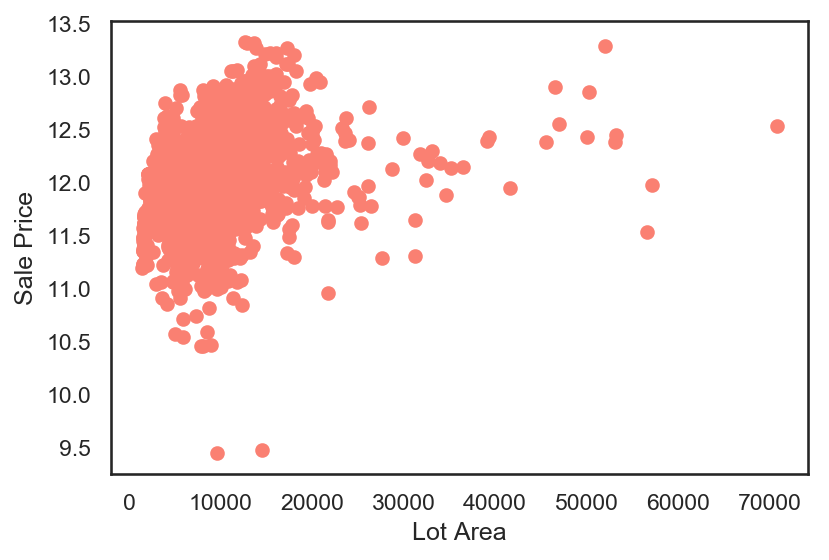

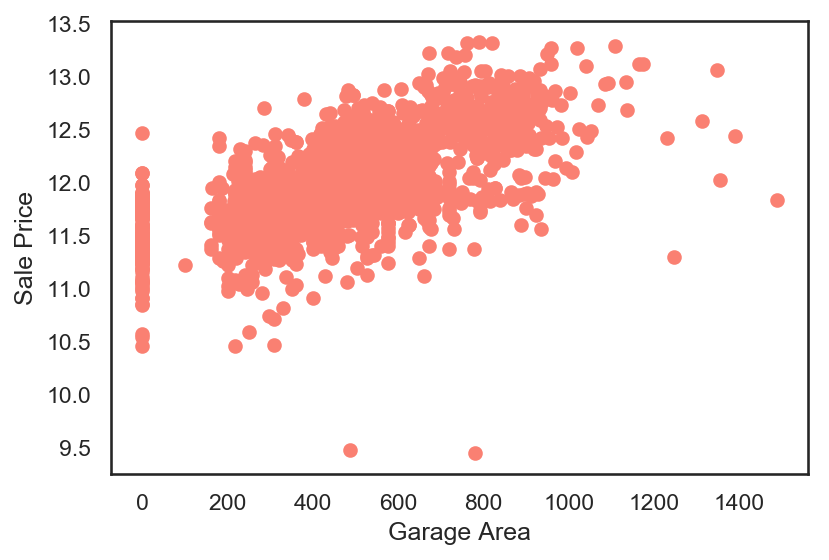

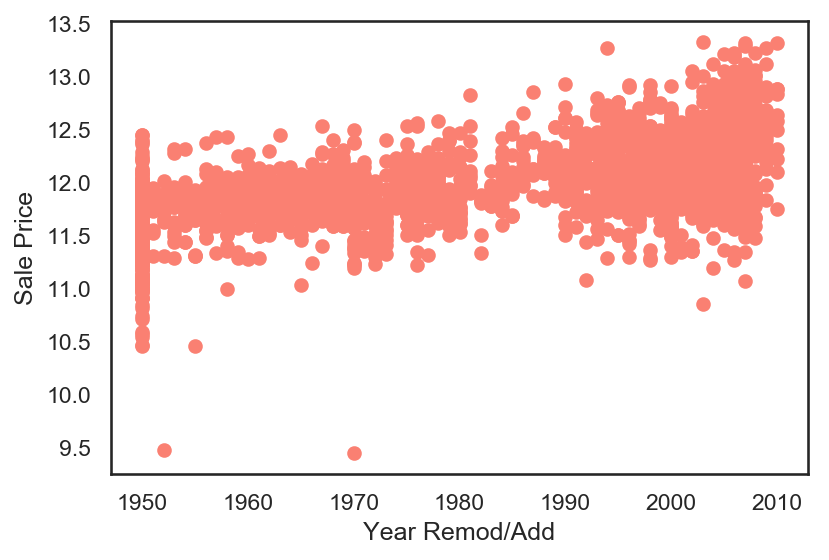

In [20]:
plt.scatter(raw_data3['Lot Area'], raw_data3['SalePrice'])
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')
plt.show()

plt.scatter(raw_data3['Garage Area'], raw_data3['SalePrice'])
plt.xlabel('Garage Area')
plt.ylabel('Sale Price')
plt.show()

plt.scatter(raw_data3['Year Remod/Add'], raw_data3['SalePrice'])
plt.xlabel('Year Remod/Add')
plt.ylabel('Sale Price')
plt.show()

poly_features = ['Lot Area', 'Garage Area', 'Year Remod/Add']

We will add polynomial features in order to attempt to make them more useful:

In [21]:
# Print old size
print(clean_data.shape)

# Add poly features

def addpoly(df):
    # Work on a copy
    df = df.copy()
    
    for c in poly_features:
        for d in [0.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
        
    return df

clean_data = addpoly(clean_data)

#Print new size
print(clean_data.shape) # out 2391, 384

(2201, 71)
(2201, 80)


## Save clean data

In [22]:
clean_data = clean_data.drop('SalePrice$', axis = 1).copy()

#Print final clean data size
print('Final clean data size:', clean_data.shape)

#Save
clean_data.to_csv('clean_data.csv')

Final clean data size: (2201, 79)


# Correlations
---

One last thing we'll do before modelling is quickly run correlations between all continuous variables. This will help us to decide which features to include in the simple and intermediate models.

In [23]:
corr_matrix = clean_data.corr()['SalePrice'].sort_values(ascending=False)
corr_matrix

SalePrice              1.000000
Overall Qual           0.820939
Gr Liv Area            0.720819
Exter Qual             0.691786
Garage Cars            0.687400
Bsmt Qual              0.682207
Garage Area            0.661569
Kitchen Qual           0.655997
Garage Area**2         0.635007
Total Bsmt SF          0.625389
Garage Area**0.5       0.603064
Full Bath              0.598295
Year Remod/Add**3      0.589375
Year Remod/Add**2      0.589278
Year Remod/Add         0.589174
Year Remod/Add**0.5    0.589120
1st Flr SF             0.585832
Garage Area**3         0.580395
Fireplaces             0.507219
Heating QC             0.491162
TotRms AbvGrd          0.486940
Open Porch SF          0.473192
Mas Vnr Area           0.440684
Lot Area**0.5          0.371129
Lot Area               0.368580
Lot Frontage           0.357035
Bsmt Exposure          0.350945
Wood Deck SF           0.349219
Lot Area**2            0.323884
Half Bath              0.299749
Lot Area**3            0.253178
Bsmt Ful

# Modelling
---

We will create 3 models. The Simple model has 2 predictors. The Intermediate model has 20 variables. The Complex model uses all features as well as the 9 polynomial features. The Complex model comes in 2 versions: one Ridge regression with default alpha, and another one with hyperparameter tuning using grid search. We also computed the baseline so that we can make comparisons. Overall, the **validation** MAEs range from approximately 32,000 dollars (Simple model) to 12,300 dollars (Complex model with best alpha), compared to a baseline of 49,300 dollars. The best model has a **validation** R-squared of 0.9, meaning that it explains roughly 90% of the variance in SalePrice.

## Simple model

We will start with a very basic model, which has only 2 predictor variables: the ground living area of the house (Gr Liv Area), and whether or not the house was renovated just before the sale (Renovated before sale). 

We chose Gr Liv Area because it it highly correlated with Sale Price (it is second after Overall Qual, however Overall Qual is ordinal and we wanted a continuous variable here). We chose Renovated before sale because we have shown above that this feature makes a big difference in Sale Price, and also because we wanted to include a categorical variable. 

In [24]:
# Select features
model1 = clean_data[['Gr Liv Area', 'Renovated before sale', 'SalePrice']]
print('Size of data for model 1:', model1.shape)

# Get dummies for Renovated before sale
model1 = pd.get_dummies(model1, columns = ['Renovated before sale'], drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model1['Renovated before sale_Yes'] = model1['Renovated before sale_Yes'].astype(float)

# Define X and y
X = model1.drop('SalePrice', axis=1).values
y = model1.SalePrice.values
print('X size:', X.shape, 'y size:', y.shape)

# Split data into train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=0) # we use 0.4 to have roughly 1000 samples in test set
print('X_tr size:', X_tr.shape, 'y_tr size:', y_tr.shape)
print('X_te size:', X_te.shape, 'y_te size:', y_te.shape)

# Standardize input features
scaler_simple = StandardScaler()
X_tr_rescaled = scaler_simple.fit_transform(X_tr)
X_te_rescaled = scaler_simple.transform(X_te)

Size of data for model 1: (2201, 3)
X size: (2201, 2) y size: (2201,)
X_tr size: (1650, 2) y_tr size: (1650,)
X_te size: (551, 2) y_te size: (551,)


In [25]:
lr_1 = LinearRegression()
lr_1.fit(X_tr_rescaled, y_tr) #fit to TRAIN data

baseline = np.mean(np.abs(np.expm1(y_te) - np.median(np.expm1(y_tr)))) # compute baseline MAE

print('Baseline MAE {:.4f}'.format(baseline)) # print baseline
print('Train MAE: {:.4f}'.format(MAE(np.expm1(y_tr), np.expm1(lr_1.predict(X_tr_rescaled))))) # print MAE of model predicting TRAIN data
print('Test MAE: {:.4f}'.format(MAE(np.expm1(y_te), np.expm1(lr_1.predict(X_te_rescaled))))) # print MAE of model predicting TEST data
print('Train R2: {:.4f}'.format(lr_1.score(X_tr_rescaled, y_tr))) # compute TRAIN R-squared
print('Test R2: {:.4f}'.format(lr_1.score(X_te_rescaled, y_te))) # compute TEST R-squared

Baseline MAE 49362.0708
Train MAE: 32035.6948
Test MAE: 32017.2853
Train R2: 0.5946
Test R2: 0.5361


We get a mean absolute error (MAE) of approximately 32,000, meaning that our predictions are wrong by 32,000 dollars on average, which is better than our baseline MAE of 49,000 dollars.

## Intermediate model

For our intermediate model, we simply selected the 10 continuous features that have the highest (positive or negative) correlations with SalePrice. We selected the 10 categorical variables on what we guessed were the most relevant ones, and also by visual inspection of the bar plots presented above (i.e., those with data well spread between categories, which arguably mean a difference in SalePrice as illustrated with Renovate before sale).

In [26]:
# Select features
model2 = clean_data[['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual', # continuous variables
                     'Total Bsmt SF', 'Garage Cars', '1st Flr SF', 'Garage Area', 'Year Built', 'Bsmt Qual',
                     'MS SubClass', 'Alley', 'Lot Shape', 'Neighborhood', 'House Style', # categorical variables
                     'Mas Vnr Type', 'Foundation', 'Basement', 'Garage Type', 'Renovated before sale',
                     'SalePrice']] # output variable
print('Size of data for model 2:', model2.shape)


# cube: Bsmt Qual

# Get dummies
model2 = pd.get_dummies(model2, columns = ['MS SubClass', 'Alley', 'Lot Shape', 'Neighborhood', 'House Style', 'Mas Vnr Type', 'Foundation', 'Basement', 'Garage Type', 'Renovated before sale'], drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model2['Renovated before sale_Yes'] = model2['Renovated before sale_Yes'].astype(float)

# Define X and y
X = model2.drop('SalePrice', axis=1).values
y = model2.SalePrice.values
print('X size:', X.shape, 'y size:', y.shape)

# Split data into train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=0) # we use 0.25 to have roughly 500 samples in test set
print('X_tr size:', X_tr.shape, 'y_tr size:', y_tr.shape)
print('X_te size:', X_te.shape, 'y_te size:', y_te.shape)

# Standardize input features
scaler_int = StandardScaler()
X_tr_rescaled = scaler_int.fit_transform(X_tr)
X_te_rescaled = scaler_int.transform(X_te)

Size of data for model 2: (2201, 21)
X size: (2201, 78) y size: (2201,)
X_tr size: (1650, 78) y_tr size: (1650,)
X_te size: (551, 78) y_te size: (551,)


In [27]:
## using LR
lr_2 = LinearRegression()
lr_2.fit(X_tr_rescaled, y_tr) #fit to TRAIN data

print('Train MAE: {:.4f}'.format(MAE(np.expm1(y_tr), np.expm1(lr_2.predict(X_tr_rescaled))))) # print MAE of model predicting TRAIN data 
print('Test MAE: {:.4f}'.format(MAE(np.expm1(y_te), np.expm1(lr_2.predict(X_te_rescaled))))) # print MAE of model predicting TEST data   
print('Train R2: {:.4f}'.format(lr_2.score(X_tr_rescaled, y_tr))) # compute TRAIN R-squared                          
print('Test R2: {:.4f}'.format(lr_2.score(X_te_rescaled, y_te))) # compute TEST R-squared                            

Train MAE: 14359.2116
Test MAE: 16008.3981
Train R2: 0.9046
Test R2: 0.8549


# Complex model

In [28]:
model4 = clean_data.drop(['Order', 'PID'], axis=1)
model4.shape # out 2391, 76

(2201, 77)

In [29]:
# Get dummies
model4 = pd.get_dummies(model4, drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model2['Renovated before sale_Yes'] = model2['Renovated before sale_Yes'].astype(float)

In [30]:
# Define X and y
X = model4.drop('SalePrice', axis=1).values
y = model4.SalePrice.values

In [31]:
# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=0)

# Standardize features
scaler_complex = StandardScaler()
X_tr_rescaled = scaler_complex.fit_transform(X_tr)
X_te_rescaled = scaler_complex.transform(X_te)

In [32]:
#ridge regression with default alpha = 1
ridge = Ridge()
ridge.fit(X_tr_rescaled, y_tr)

print('Train MAE: {:.4f}'.format(MAE(np.expm1(y_tr), np.expm1(ridge.predict(X_tr_rescaled)))))
print('Test MAE: {:.4f}'.format(MAE(np.expm1(y_te), np.expm1(ridge.predict(X_te_rescaled)))))
print('Train R2: {:.4f}'.format(ridge.score(X_tr_rescaled, y_tr)))
print('Test R2: {:.4f}'.format(ridge.score(X_te_rescaled, y_te)))

Train MAE: 10491.5907
Test MAE: 12278.0955
Train R2: 0.9498
Test R2: 0.8990


### Hyperparameter tuning

C:\Users\jeanl\anaconda3\envs\exts-ml\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jeanl\anaconda3\envs\exts-ml\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jeanl\anaconda3\envs\exts-ml\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


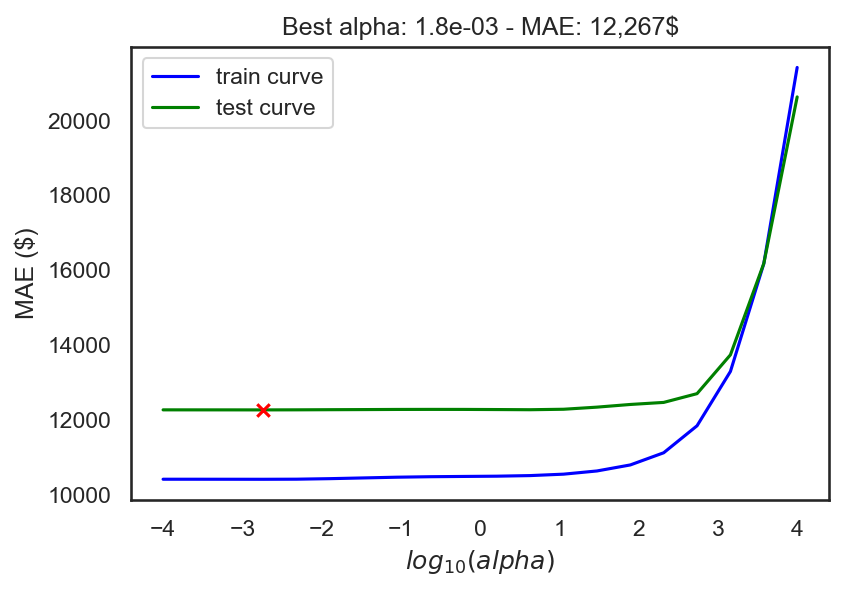

Best alpha: 0.0018329807108324356
Final model MAE: 12266.669663383553


In [33]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=20):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'model': ridge,
        'alpha': alpha,
        'train_mae': MAE(np.expm1(y_tr), np.expm1(ridge.predict(X_tr_rescaled))),
        'test_mae': MAE(np.expm1(y_te), np.expm1(ridge.predict(X_te_rescaled))),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.plot(np.log10(gs_results['alpha']), gs_results['train_mae'], label='train curve', c='blue')
plt.plot(np.log10(gs_results['alpha']), gs_results['test_mae'], label='test curve', c='green')

# Mark best alpha value
best_result = gs_results.loc[gs_results.test_mae.idxmin()]
plt.scatter(np.log10(best_result.alpha), best_result.test_mae, marker='x', c='red', zorder=10)
plt.title('Best alpha: {:.1e} - MAE: {:,.0f}$'.format(best_result.alpha, best_result.test_mae))

plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE ($)')
plt.legend()
plt.show()

print('Best alpha:', best_result.alpha) # print best alpha for test data
print('Final model MAE:', best_result.test_mae) # print best mae for test data

# This code comes mainly from the Course materials

We have one last thing to do, which is to re-run the Ridge regression with the best alpha found. If it is correct, then we should get the same MAE.

In [34]:
#ridge regression with best alpha
ridge_tuned = Ridge(alpha=best_result.alpha)
ridge_tuned.fit(X_tr_rescaled, y_tr)

print('Train MAE: {:.4f}'.format(MAE(np.expm1(y_tr), np.expm1(ridge_tuned.predict(X_tr_rescaled)))))
print('Test MAE: {:.4f}'.format(MAE(np.expm1(y_te), np.expm1(ridge_tuned.predict(X_te_rescaled)))))
print('Train R2: {:.4f}'.format(ridge_tuned.score(X_tr_rescaled, y_tr)))
print('Test R2: {:.4f}'.format(ridge_tuned.score(X_te_rescaled, y_te)))

Train MAE: 10412.6425
Test MAE: 12266.6697
Train R2: 0.9504
Test R2: 0.8996


And indeed we found that the test MAE is the same as above. We can finally plot the results of all our models:

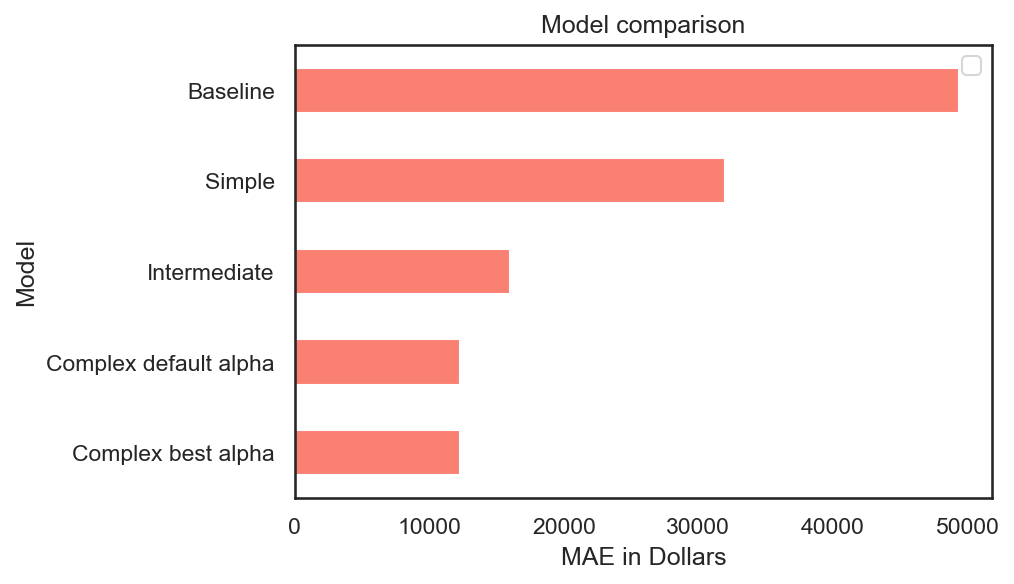

In [35]:
results = pd.DataFrame({
        'Model': ['Baseline', 'Simple', 'Intermediate', 'Complex default alpha', 'Complex best alpha'],
        'Test MAE': [49362, 32017, 16008, 12278, 12267]
})
results.sort_values(by='Test MAE', ascending=True, inplace=True)
results.plot.barh(x='Model', y='Test MAE')
plt.title('Model comparison')
plt.xlabel('MAE in Dollars')
plt.legend('')
plt.show()

We see a clear improvement between the 3 overall models (Simple, Intermediate, and Complex) and the baseline, as well as between them.

# Predictions
---

We will make our predictions based on the Simple model, the Intermediate model, and the Complex model with hyperparameter tuning.

In [36]:
# Load raw test data
raw_data = pd.read_csv('house-prices-test.csv') # load data
print(raw_data.shape) # print df size. Also note raw test data has one column less than raw train data, because SalePrice is not included
raw_data.head()

(500, 81)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,92,0,NaN,NaN,NaN,0,10,2009,WD,Normal
2,2397,528144030,60,RL,86.0,11065,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,10,2006,New,Partial
3,1963,535452060,20,RL,70.0,7000,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnWw,NaN,0,4,2007,WD,Family
4,306,911202100,50,C (all),66.0,8712,Pave,Pave,Reg,HLS,...,0,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml


## Apply cleaning to test data

We first need to clean the 500 test samples. The code below is nearly the same as above, with a few differences:

In [37]:
# Apply cleaning to raw test data

# Duplicates
print('Duplicated rows:', raw_data.duplicated().sum()) # check for perfect duplicates
print('Duplicated IDs:', raw_data.duplicated(subset=('PID')).sum()) # check for duplicated IDs

# Missing values
print('Missing values:', raw_data.isnull().sum().sum()) # print sum of missing values accross all features
nan = raw_data.isnull().sum().to_frame('n') # sum missing values by feature, put to a df
print(nan[nan['n'] > 0].sort_values(by='n', ascending=False)) # print features with missing values and missing values number
nan_percent = nan[nan['n'] > 0].sort_values(by='n')/ raw_data.shape[0] * 100
# Drop 'Pool Qc', 'Misc Feature', and 'Fireplace Qu'
raw_data2 = raw_data.drop(['Pool QC', 'Misc Feature', 'Fireplace Qu'], axis = 1) # drop features
# Recode 'Alley' and 'Fence' to yes/no
raw_data2['Alley'] = raw_data2['Alley'].replace({'Grvl':'Yes', 'Pave':'Yes'}).fillna(value='No') # Alley
raw_data2['Fence'] = raw_data2['Fence'].replace({'MnPrv':'Yes', 'GdPrv':'Yes', 'GdWo':'Yes', 'MnWw':'Yes'}).fillna(value='No') # Fence
# Replace 'Lot Frontage' missing values by median
raw_data2['Lot Frontage'] = raw_data2['Lot Frontage'].fillna(value=raw_data2['Lot Frontage'].median())
# Create yes/no feature for Garage and Basement
raw_data2['Garage'] = raw_data2['Garage Type'].replace({'Attchd':'Yes', 'Detchd':'Yes', 'BuiltIn':'Yes', 'Basment':'Yes', '2Types':'Yes', 'CarPort':'Yes'}).fillna(value='No')
raw_data2['Basement'] = raw_data2['Bsmt Qual'].replace({'TA':'Yes', 'Gd':'Yes', 'Ex':'Yes', 'Fa':'Yes', 'Po':'Yes'}).fillna(value='No')
# Replace missing values in Garage and Basement features with most frequent category
raw_data2['Garage Type'].fillna(value=raw_data2['Garage Type'].value_counts().index[0], inplace=True)
raw_data2['Garage Finish'].fillna(value=raw_data2['Garage Finish'].value_counts().index[0], inplace=True)
raw_data2['Garage Qual'].fillna(value=raw_data2['Garage Qual'].value_counts().index[0], inplace=True)
raw_data2['Garage Cond'].fillna(value=raw_data2['Garage Cond'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Exposure'].fillna(value=raw_data2['Bsmt Exposure'].value_counts().index[0], inplace=True)
raw_data2['BsmtFin Type 2'].fillna(value=raw_data2['BsmtFin Type 2'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Cond'].fillna(value=raw_data2['Bsmt Cond'].value_counts().index[0], inplace=True)
raw_data2['Bsmt Qual'].fillna(value=raw_data2['Bsmt Qual'].value_counts().index[0], inplace=True)
raw_data2['BsmtFin Type 1'].fillna(value=raw_data2['BsmtFin Type 1'].value_counts().index[0], inplace=True)
# Replace all other missing values with most frequent category or median
raw_data2['Electrical'].fillna(value=raw_data2['Electrical'].value_counts().index[0], inplace=True)
raw_data2['Garage Area'].fillna(value=raw_data2['Garage Area'].median(), inplace=True) #object
raw_data2['Total Bsmt SF'].fillna(value=raw_data2['Total Bsmt SF'].median(), inplace=True) #object
raw_data2['Bsmt Unf SF'].fillna(value=raw_data2['Bsmt Unf SF'].median(), inplace=True) #object
raw_data2['BsmtFin SF 1'].fillna(value=raw_data2['BsmtFin SF 1'].median(), inplace=True) #object
raw_data2['BsmtFin SF 2'].fillna(value=raw_data2['BsmtFin SF 2'].median(), inplace=True) #object
raw_data2['Garage Cars'].fillna(value=raw_data2['Garage Cars'].median(), inplace=True) #float
raw_data2['Bsmt Full Bath'].fillna(value=raw_data2['Bsmt Full Bath'].median(), inplace=True) #float
raw_data2['Bsmt Half Bath'].fillna(value=raw_data2['Bsmt Half Bath'].median(), inplace=True) #float
raw_data2['Mas Vnr Area'].fillna(value=raw_data2['Mas Vnr Area'].median(), inplace=True) #object
raw_data2['Mas Vnr Type'].fillna(value=raw_data2['Mas Vnr Type'].value_counts().index[0], inplace=True)
# Fix issue with 'Garage Yr Blt'
raw_data2['Garage Yr Blt'].replace({2207:2007}, inplace=True)
raw_data2['Garage Yr Blt'].fillna(value=raw_data['Garage Yr Blt'].median(), inplace=True)
# Check that all missing values have been removed
print('Remaining missing values:', raw_data2.isnull().sum().sum())

# Drop features with more than 98% of data in single category
raw_data3 = raw_data2.drop(['Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Heating'], axis = 1)
print('New df size:', raw_data3.shape, '--> note we now have 75 features')

# Recode ordinal variables
raw_data3['Exter Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Exter Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Bsmt Exposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}, inplace=True) # note smaller scale
raw_data3['Heating QC'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Kitchen Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Garage Qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)
raw_data3['Garage Cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace=True)

# Define 'MS SubClass' as categorical data
raw_data3['MS SubClass'] = raw_data3['MS SubClass'].astype('category')

# Fix error in test data
raw_data3.loc[182,'Year Built'] = 2001
raw_data3.loc[182,'Year Remod/Add'] = 2002

# Dates
raw_data3['Year Remod/Add_bis'] = raw_data3['Year Remod/Add'] - raw_data3['Year Built'] # transform renovation year to number of years between year built and renovation. Note order matters here!
raw_data3['Year Built'] = 2021 - raw_data3['Year Built'] # transform year built to number of years since house was built
raw_data3['Garage Yr Blt'] = 2021 - raw_data3['Garage Yr Blt'] # transform garage year built to number of years since garage was built (old error was here)
print(raw_data3.shape)
# Note we do not transform 'Mo Sold' and 'Yr Sold' (we just convert 'Yr Sold' to integer to avoid an issue later)


Duplicated rows: 0
Duplicated IDs: 0
Missing values: 2327
                  n
Pool QC         499
Misc Feature    484
Alley           465
Fence           417
Fireplace Qu    236
Lot Frontage     70
Garage Type      21
Garage Yr Blt    21
Garage Finish    21
Garage Qual      21
Garage Cond      21
Bsmt Cond         9
Bsmt Exposure     9
BsmtFin Type 1    9
BsmtFin Type 2    9
Bsmt Qual         9
Mas Vnr Area      3
Mas Vnr Type      3
Remaining missing values: 0
New df size: (500, 75) --> note we now have 75 features
(500, 76)


In [38]:
# log transformation
log1p_transform = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2','Bsmt Unf SF', 
          '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF',
          'Enclosed Porch', 'Bsmt Exposure', 'Year Remod/Add_bis',
          'Year Built', 'Garage Yr Blt', 'TotRms AbvGrd', 'Bedroom AbvGr', 'Fireplaces', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath',
          'Kitchen AbvGr', 'Overall Cond']
raw_data3[log1p_transform] = np.log1p(raw_data3[log1p_transform])

raw_data3 = raw_data3.drop(['BsmtFin SF 2', 'Screen Porch', 'Bsmt Cond', 'Garage Qual', 'Garage Cond', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Pool Area'], axis = 1).copy()

# Define clean test data object
clean_data = raw_data3

# Add feature
clean_data['Renovated before sale'] = clean_data['Yr Sold'] - clean_data['Year Remod/Add']

# Create function to recode as renovated before sale
def binary(x):
    if x < 2: # houses that were renovated on the same year or up to one year before the sale
        code = 'Yes'
    else:
        code = 'No'
    return code

# Apply function
clean_data['Renovated before sale'] = clean_data['Renovated before sale'].apply(binary)

print('Test data size after cleaning:', clean_data.shape)

Test data size after cleaning: (500, 69)


In [39]:
# Add polynomial features

# Print old size
print(clean_data.shape)

# Add poly features

def addpoly(df):
    # Work on a copy
    df = df.copy()
    
    for c in poly_features:
        for d in [0.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
        
    return df

clean_data = addpoly(clean_data)

#Print new size
print(clean_data.shape) # out 2391, 384



(500, 69)
(500, 78)


In [40]:
#Save
clean_data.to_csv('clean_data_test.csv')

## Simple model

We first select features, get dummies, define X and standardize X features:

In [41]:
# Select features
model1 = clean_data[['Gr Liv Area', 'Renovated before sale']]
print('Size of data for model 1:', model1.shape)

# Get dummies for Renovated before sale
model1 = pd.get_dummies(model1, columns = ['Renovated before sale'], drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model1['Renovated before sale_Yes'] = model1['Renovated before sale_Yes'].astype(float)

# Define X
X = model1.values
print('X size:', X.shape)

# Standardize input features
X_rescaled = scaler_simple.transform(X) ### using scaler of train data


Size of data for model 1: (500, 2)
X size: (500, 2)


We can now make predictions:

In [42]:
SalePrice = np.expm1(lr_1.predict(X_rescaled)) # we use lr_1, the regression created above for the simple model

And gather needed data:

In [43]:
SalePrice = SalePrice.reshape(500,1) #reshape array, which is needed to concatenate
SalePrice = pd.DataFrame(SalePrice) #transform to df
SalePrice = pd.concat([clean_data, SalePrice], axis=1) #concatenate
SalePrice = SalePrice.rename(columns={0: 'SalePrice'})[['PID', 'SalePrice']] #rename output column
print('Shape of predicted data:', SalePrice.shape)
print('Mean of predicted price:', SalePrice['SalePrice'].mean().round())
SalePrice.head()

Shape of predicted data: (500, 2)
Mean of predicted price: 182102.0


,PID,SalePrice
0,909279080,215116.503057
1,907126050,119049.416354
2,528144030,278339.142026
3,535452060,133554.436221
4,911202100,137929.041881


We can finally save our predictions in the relevant format:

In [44]:
#Save
SalePrice.to_csv('predictions-simple-model.csv', index=False)

## Intermediate model

As for the predictions from our simple model, we will first select the features and get dummies for the categorical variables:

In [45]:
# Select features
model2_b = clean_data[['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual', # continuous variables  #### ORDER MATTERS ! #############################################
                     'Total Bsmt SF', 'Garage Cars', '1st Flr SF', 'Garage Area', 'Year Built', 'Bsmt Qual',
                     'MS SubClass', 'Alley', 'Lot Shape', 'Neighborhood', 'House Style', # categorical variables
                     'Mas Vnr Type', 'Foundation', 'Basement', 'Garage Type', 'Renovated before sale'
                     ]]

# Get dummies
model2_b = pd.get_dummies(model2_b, columns = ['MS SubClass', 'Alley', 'Lot Shape', 'Neighborhood', 'House Style', 'Mas Vnr Type', 'Foundation', 'Basement', 'Garage Type', 'Renovated before sale'], drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model2_b['Renovated before sale_Yes'] = model2_b['Renovated before sale_Yes'].astype(float)

print('Size:', model2_b.shape)

Size: (500, 73)


But here we need to be careful. We notice that our data frame has 73 features, which is not equal to the number of features we had when fitting our intermediate model without outliers (i.e., Model 2 above):

In [46]:
print('Number of columns in Model 2 train data', model2.shape[1]) ### (use model3 instead of model2)
print('Number of columns in Model 2 test data', model2_b.shape[1])

Number of columns in Model 2 train data 79
Number of columns in Model 2 test data 73


Indeed our intermediate model dataframe had 79, not 73 features. And if we were to proceed with predictions, we would get an error that the number of features is not the same!

To solve this, let's first spot the missing features in our preprocessed test data:

In [47]:
model2.columns.difference(model2_b.columns) # columns that are in train data but not in test data
# Check: https://stackoverflow.com/questions/45482755/compare-headers-of-dataframes-in-pandas

Index(['Foundation_Wood', 'MS SubClass_150', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'SalePrice'],
      dtype='object')

'SalePrice' is not in our preprocessed test data, which is normal--it was not provided to us since that is our job to predict it!

However, we have 5 features that are not in our preprocessed test data but that were in our intermediate model. We notice that they are all dummy variables. And the best explanation for why they are missing must simply be that in the test data, no houses were possessing these properties. For example, 'Foundation_Wood' was not created in test data just because no house has a wood foundation in the test data. And this means that we can apply a simple solution here, which is just to add these properties to the test data, coding them as 0 to indicate that the houses do no possess these properties. Let's do this then:

In [48]:
# Add missing features and code them as 0
model2_b['Foundation_Wood'] = 0
model2_b['MS SubClass_150'] = 0
model2_b['Neighborhood_Greens'] = 0
model2_b['Neighborhood_GrnHill'] = 0
model2_b['Neighborhood_Landmrk'] = 0

# Recheck data size
print('Corrected size:', model2_b.shape)

Corrected size: (500, 78)


Our preprocessed data now has 78 columns, which is exactly what we need. Indeed our intermediate model consisted of 78 input variables and 1 input variable. That said, importantly, we also need to check that our variables are in the **same order**:

In [49]:
# Apply order of train data to test data
model2_b = model2_b.reindex(model2.columns, axis=1)

# Drop SalePrice from sorted test data
model2_b = model2_b.drop('SalePrice', axis=1)

# Reprint shapes
print('Model 2 size   :', model2.shape)
print('Model 2 b size:', model2_b.shape)

# Check: https://stackoverflow.com/questions/11067027/re-ordering-columns-in-pandas-dataframe-based-on-column-name

Model 2 size   : (2201, 79)
Model 2 b size: (500, 78)


We can now proceed:

In [50]:
# Define X
X = model2_b.values

# Standardize input features
X_rescaled = scaler_int.transform(X) ### using scaler of train data

#Predict
SalePrice2 = np.expm1(lr_2.predict(X_rescaled)) # we use lr_2, i.e. the regression created above for the intermediate model

In [51]:
SalePrice2 = SalePrice2.reshape(500,1)
SalePrice2 = pd.DataFrame(SalePrice2)
SalePrice2 = pd.concat([clean_data, SalePrice2], axis=1)
SalePrice2 = SalePrice2.rename(columns={0: 'SalePrice'})[['PID', 'SalePrice']]
print('Shape of predicted data:', SalePrice2.shape)
print('Mean of predicted price:', SalePrice2['SalePrice'].mean().round())
SalePrice2.head()

Shape of predicted data: (500, 2)
Mean of predicted price: 182018.0


,PID,SalePrice
0,909279080,198148.319191
1,907126050,128212.842290
2,528144030,302517.514877
3,535452060,129955.682977
4,911202100,92912.783247


In [52]:
SalePrice2.to_csv('predictions-intermediate-model.csv', index=False)

## Complex model

We proceed in a similar way as for our Intermediate model. Please note code and steps that are identical or extremely similar are not commented on.

In [53]:
model4_b = clean_data.drop(['Order', 'PID'], axis=1)
model4_b.shape

(500, 76)

In [54]:
# Get dummies
model4_b = pd.get_dummies(model4_b, drop_first = True) # note we drop first column

# Convert dummy to float to avoid warning when scaling data
model4_b['Renovated before sale_Yes'] = model4_b['Renovated before sale_Yes'].astype(float)

print('Size:', model4_b.shape)

Size: (500, 198)


In [55]:
print('Number of columns in Model 4 train data', model4.shape[1])
print('Number of columns in Model 4 test data', model4_b.shape[1])

Number of columns in Model 4 train data 216
Number of columns in Model 4 test data 198


In [56]:
model4.columns.difference(model4_b.columns)

Index(['Exterior 1st_AsphShn', 'Exterior 1st_BrkComm', 'Exterior 1st_CBlock',
       'Exterior 1st_ImStucc', 'Exterior 1st_PreCast', 'Exterior 1st_Stone',
       'Exterior 2nd_AsphShn', 'Exterior 2nd_PreCast', 'Foundation_Wood',
       'Functional_Sev', 'Land Slope_Sev', 'MS SubClass_150',
       'MS Zoning_I (all)', 'Neighborhood_Greens', 'Neighborhood_GrnHill',
       'Neighborhood_Landmrk', 'Roof Style_Shed', 'Sale Type_Con',
       'Sale Type_VWD', 'SalePrice'],
      dtype='object')

In [57]:
# Add missing features and code them as 0

model4_b['Exterior 1st_AsphShn'] = 0
model4_b['Exterior 1st_BrkComm'] = 0
model4_b['Exterior 1st_CBlock'] = 0
model4_b['Exterior 1st_ImStucc'] = 0
model4_b['Exterior 1st_PreCast'] = 0
model4_b['Exterior 1st_Stone'] = 0
model4_b['Exterior 2nd_AsphShn'] = 0
model4_b['Exterior 2nd_PreCast'] = 0
model4_b['Foundation_Wood'] = 0
model4_b['Functional_Sev'] = 0
model4_b['Land Slope_Sev'] = 0
model4_b['MS SubClass_150'] = 0 # added
model4_b['MS Zoning_I (all)'] = 0
model4_b['Neighborhood_Greens'] = 0
model4_b['Neighborhood_GrnHill'] = 0
model4_b['Neighborhood_Landmrk'] = 0
model4_b['Roof Style_Shed'] = 0
model4_b['Sale Type_Con'] = 0
model4_b['Sale Type_VWD'] = 0

# Recheck data size
print('Corrected size:', model4_b.shape)

# Removed
#model4_b['Electrical_Mix'] = 0
#model4_b['MS Zoning_C (all)'] = 0
#model4_b['Mas Vnr Type_CBlock'] = 0
#model4_b['MS SubClass_150.0'] = 0

Corrected size: (500, 217)


In [58]:
# But now there are 2 more
model4_b.columns.difference(model4.columns)

Index(['Exterior 2nd_Other', 'Functional_Sal'], dtype='object')

In [59]:
# Let's remove these
model4_b = model4_b.drop(['Exterior 2nd_Other'], axis=1)
model4_b = model4_b.drop(['Functional_Sal'], axis=1)
print('Final size of train data:', model4_b.shape)

Final size of train data: (500, 215)


In [60]:
# Reorder
# Apply order of train data to test data
model4_b = model4_b.reindex(model4.columns, axis=1)

# Drop SalePrice from sorted test data
model4_b = model4_b.drop('SalePrice', axis=1)

# Reprint shapes
print('Model 2 size   :', model4.shape)
print('Model 2 b size:', model4_b.shape)

Model 2 size   : (2201, 216)
Model 2 b size: (500, 215)


In [61]:
# We can now proceed...

In [62]:
# Define X
X = model4_b.values

# Apply scaling
X_rescaled = scaler_complex.transform(X) ### using scaler of train data

#Predict
SalePrice3 = np.expm1(ridge_tuned.predict(X_rescaled)) # we use ridge_tuned, the regression created above for the complex model

In [63]:
SalePrice3 = SalePrice3.reshape(500,1)
SalePrice3 = pd.DataFrame(SalePrice3)
SalePrice3 = pd.concat([clean_data, SalePrice3], axis=1)
SalePrice3 = SalePrice3.rename(columns={0: 'SalePrice'})[['PID', 'SalePrice']]
SalePrice3.SalePrice = SalePrice3.SalePrice ### reverse log-transformation to get Sale Price in correct scale
print('Shape of predicted data:', SalePrice3.shape)
print('Mean of predicted price:', SalePrice3['SalePrice'].mean().round())
SalePrice3.head()

Shape of predicted data: (500, 2)
Mean of predicted price: 178432.0


,PID,SalePrice
0,909279080,214545.090590
1,907126050,153406.737767
2,528144030,290453.911400
3,535452060,126279.849618
4,911202100,89161.087518


In [64]:
#Save
SalePrice3.to_csv('predictions-complex-model.csv', index=False)